<a href="https://colab.research.google.com/github/datle2403/datle2403/blob/main/When_layer_become_transformer_tfv2_pet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd

In [38]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
df=pd.read_csv(csv_file)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11537 entries, 0 to 11536
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Type           11537 non-null  object
 1   Age            11537 non-null  int64 
 2   Breed1         11537 non-null  object
 3   Gender         11537 non-null  object
 4   Color1         11537 non-null  object
 5   Color2         11537 non-null  object
 6   MaturitySize   11537 non-null  object
 7   FurLength      11537 non-null  object
 8   Vaccinated     11537 non-null  object
 9   Sterilized     11537 non-null  object
 10  Health         11537 non-null  object
 11  Fee            11537 non-null  int64 
 12  Description    11528 non-null  object
 13  PhotoAmt       11537 non-null  int64 
 14  AdoptionSpeed  11537 non-null  int64 
dtypes: int64(4), object(11)
memory usage: 1.3+ MB


In [40]:
df['target'] = np.where(df['AdoptionSpeed']==4, 0, 1)

In [41]:
df.drop(['Description','AdoptionSpeed'], axis=1, inplace=True)

In [42]:
from sklearn.model_selection import train_test_split
train, test= train_test_split(df, train_size=0.9)
def df_to_dataset(df, shuffle=False, batch_size=32):
  df=df.copy()
  label=df.pop('target')
  #df={key: value[:,tf.newaxis] for key,value in df.items()}
  dataset= tf.data.Dataset.from_tensor_slices((dict(df), label))
  if shuffle:
    dataset.shuffle(len(df))
  return dataset.batch(batch_size).prefetch(batch_size)

In [45]:

ex=df_to_dataset(train, shuffle=True, batch_size=32)
ex= ex.take(1)

<TakeDataset element_spec=({'Type': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'Age': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'Breed1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'Gender': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'Color1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'Color2': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'MaturitySize': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'FurLength': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'Vaccinated': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'Sterilized': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'Health': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'Fee': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'PhotoAmt': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [49]:
[(train_features, label_batch)]=ex
train_features['Type'], label_batch

(<tf.Tensor: shape=(32,), dtype=string, numpy=
 array([b'Cat', b'Dog', b'Cat', b'Dog', b'Dog', b'Dog', b'Dog', b'Dog',
        b'Dog', b'Dog', b'Dog', b'Dog', b'Dog', b'Dog', b'Dog', b'Dog',
        b'Dog', b'Dog', b'Dog', b'Cat', b'Cat', b'Cat', b'Dog', b'Cat',
        b'Dog', b'Cat', b'Cat', b'Cat', b'Dog', b'Dog', b'Cat', b'Cat'],
       dtype=object)>, <tf.Tensor: shape=(32,), dtype=int64, numpy=
 array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1])>)

# Apply the Keras preprocessing layers

In [54]:

def get_normalization_layer(name, ds):
  normalizer= layers.Normalization(axis=None)

  feature_ds= ds.map(lambda x,y: x[name])

  normalizer.adapt(feature_ds)
  return normalizer


In [61]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))
     

In [65]:
test_type_col = train_features['Type']
train_ds= df_to_dataset(train, shuffle=True, batch_size=32)
d= get_category_encoding_layer('Type', train_ds, 'string', max_tokens=None)
d(test_type_col)


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 1.], dtype=float32)>

In [67]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

all_inputs = []
encoded_features = []

# Numerical features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  print(encoded_numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_2/truediv:0', description="created by layer 'normalization_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_3/truediv:0', description="created by layer 'normalization_3'")


In [68]:
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [69]:
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [72]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [90]:
encoded_features

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_3')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_1')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_2')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_3')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_4')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_5')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_6')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_7')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_8')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_9')>,
 <KerasTensor: shape=(None, 4) dtype=flo

In [74]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

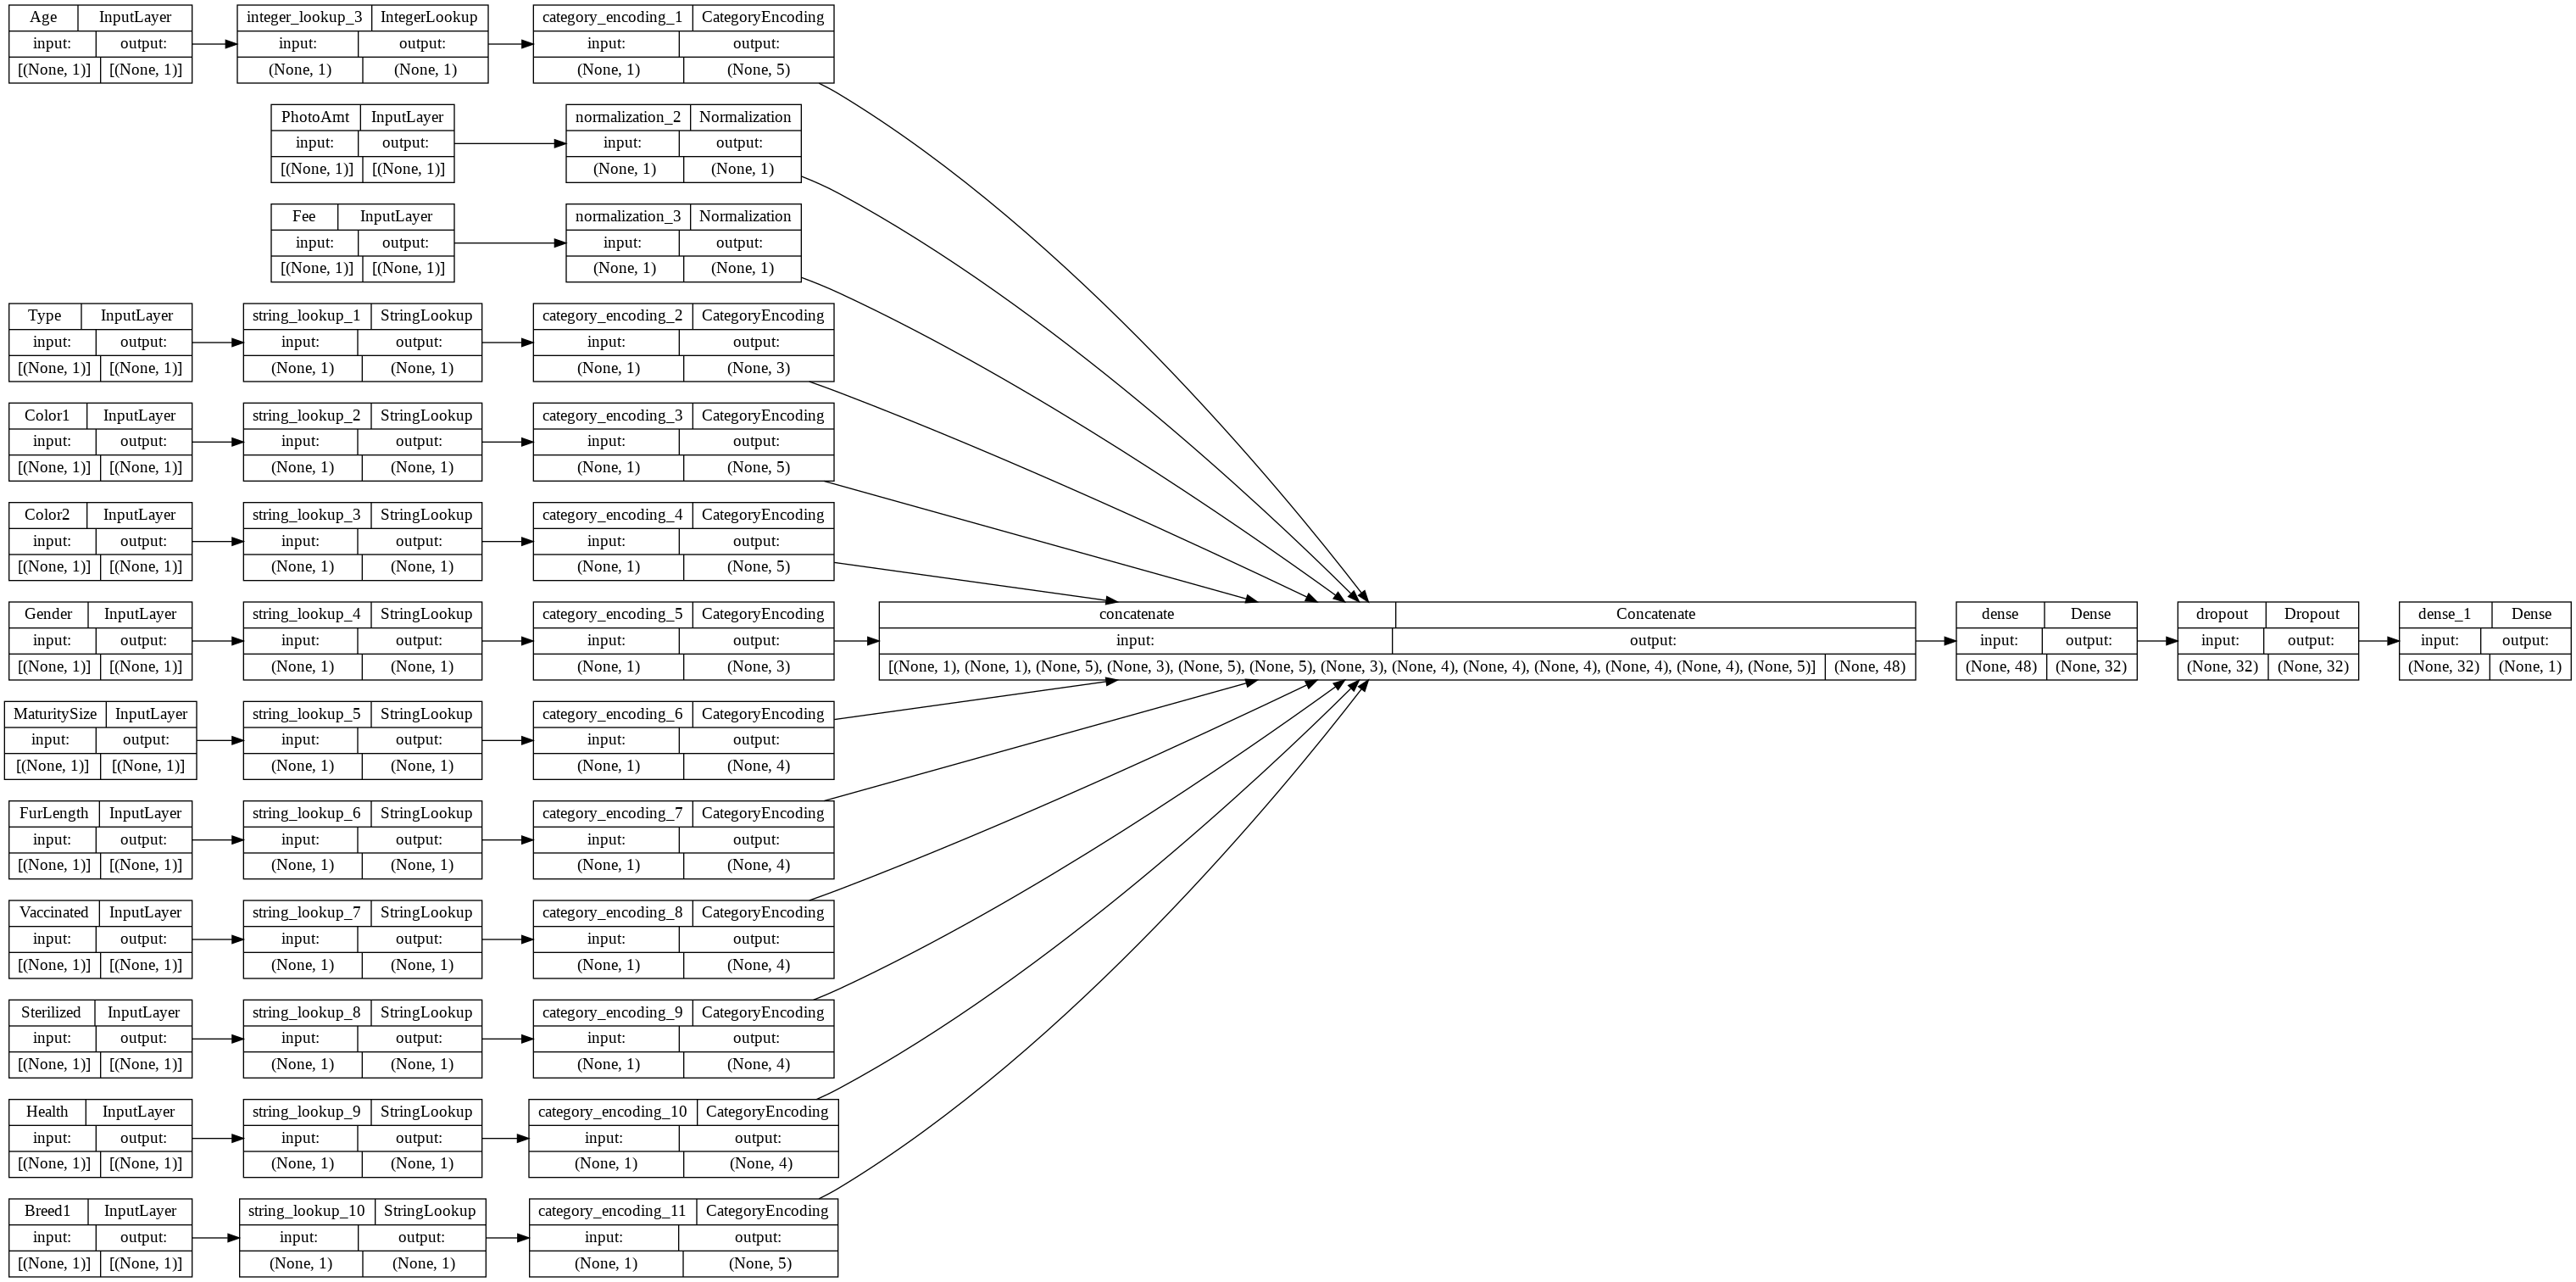

In [75]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [78]:
model.fit(train_ds, epochs=100, validation_data=test_ds)

Epoch 1/100
41/41 [==============================] - 0s 5ms/step - loss: 0.5170 - accuracy: 0.7321 - val_loss: 0.5024 - val_accuracy: 0.7522
Epoch 2/100
41/41 [==============================] - 0s 10ms/step - loss: 0.5145 - accuracy: 0.7335 - val_loss: 0.5013 - val_accuracy: 0.7470
Epoch 3/100
41/41 [==============================] - 0s 5ms/step - loss: 0.5145 - accuracy: 0.7337 - val_loss: 0.5011 - val_accuracy: 0.7496
Epoch 4/100
41/41 [==============================] - 0s 5ms/step - loss: 0.5139 - accuracy: 0.7334 - val_loss: 0.5010 - val_accuracy: 0.7487
Epoch 5/100
41/41 [==============================] - 0s 5ms/step - loss: 0.5119 - accuracy: 0.7330 - val_loss: 0.5005 - val_accuracy: 0.7496
Epoch 6/100
41/41 [==============================] - 0s 5ms/step - loss: 0.5099 - accuracy: 0.7327 - val_loss: 0.5006 - val_accuracy: 0.7452
Epoch 7/100
41/41 [==============================] - 0s 5ms/step - loss: 0.5097 - accuracy: 0.7391 - val_loss: 0.5002 - val_accuracy: 0.7452
Epoch 8/100


In [82]:
li = np.array([5, 7, 22, 97, 54, 62, 77, 23, 73, 61])
 
final_list = list(map(lambda x: x*2, li))
final_list

[10, 14, 44, 194, 108, 124, 154, 46, 146, 122]

In [83]:
e= li.map(lambda x: x+1)
e

AttributeError: ignored